In [1]:
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, sin_beta
import utils.plotting as plotting
from utils.eval import eval_predictions, format_latex_table
import numpy as np

2026-02-19 16:53:31.508687: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-19 16:53:31.547266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-19 16:53:33.715594: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
E0000 00:00:1771530817.093617  742485 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will n

Set the default float type to float64


In [2]:
t_0, t_f, N = 0, 50, 100
nop_data = 50
S0, I0, R0 = 99, 1, 0
noise_std = N * 0.01
data_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(sin_beta, 
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(data_t)
sir_data = rkdata.generate(data_t, noise_std)

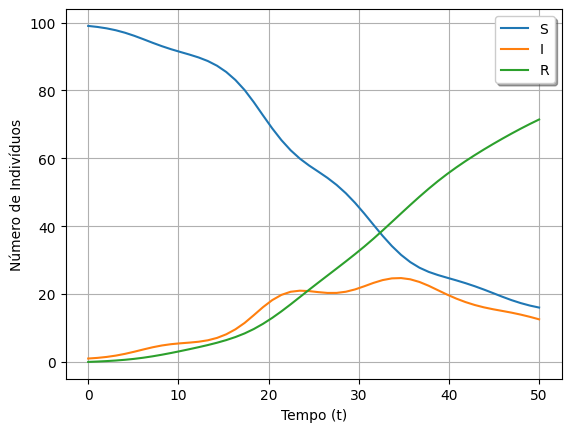

In [3]:
plotting.plot_rk_curves(data_t, sir_real, "rk-curves-sin-beta-noise")

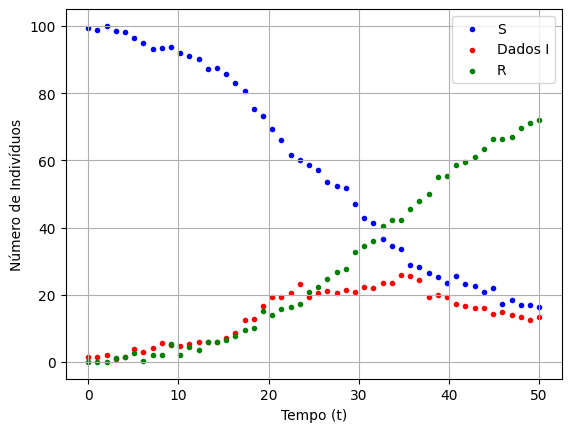

In [4]:
plotting.plot_rk_data(data_t, sir_data, figname="rk-data-sin-beta-noise")

In [5]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], data_t,
    N=N,
    hidden_layer_size=30,
    n_hidden_layers=5,
    w_physics=5000,
    w_beta_smoothness=0.01,
    scaling="min/max",
    activation="tanh",
    init_distribution="normal",
    adam_iterations=300000,
    # parallel_pinns=True,
    estimate_beta=True,
    es_min_delta=1e-4,
    beta_estimation_window=3,
    # early_stopping=False,
    # beta_hard_constraints=False,
    # adaptative_wdata=True,
    fine_tunning_using_lbfgs=False)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.005151 s



(np.float64(3.9696080648287326),
 np.float64(0.01853466873802748),
 np.float64(0.2829351100656275))

In [6]:
model.train()

(<deepxde.model.LossHistory at 0x7f545368c350>,
 <deepxde.model.TrainState at 0x7f5453b9bcd0>)

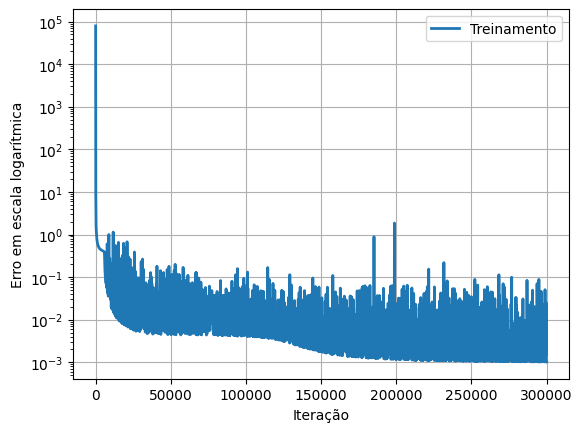

In [7]:
plotting.plot_losshistory(model.losshistory, "loss-sin-beta-noise")

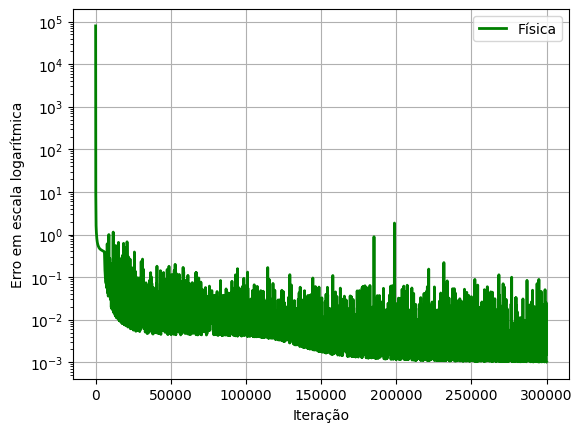

In [8]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-physics-sin-beta-noise")

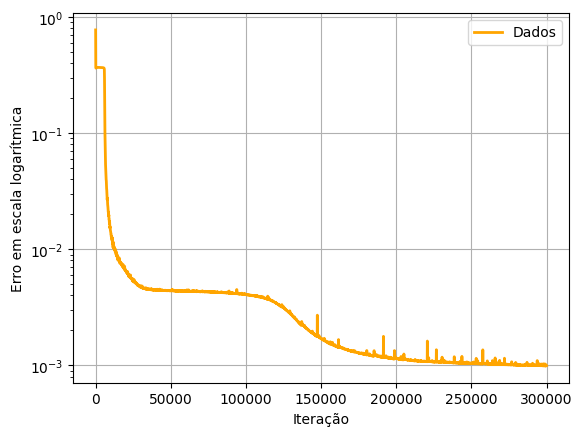

In [9]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-sin-beta-noise")

In [10]:
test_t = np.linspace(t_0, t_f, nop_data)
predictions = model.predict(test_t)

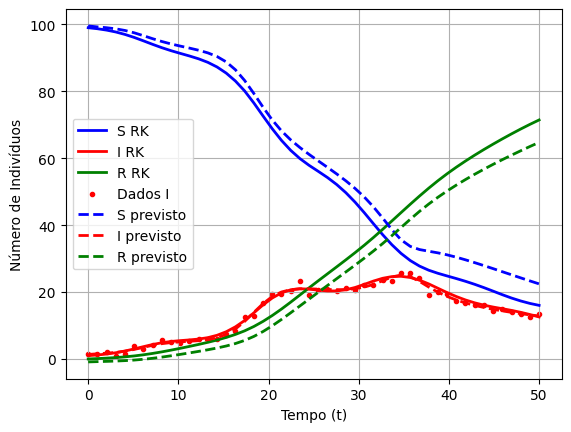

In [11]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N,
    figname="results-sin-beta-noise")

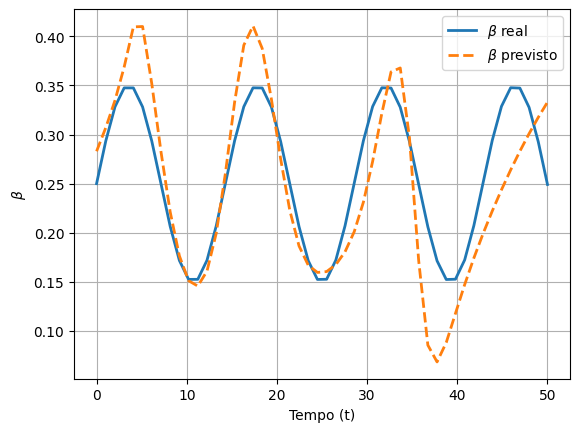

In [12]:
real_beta = sin_beta(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t, 
    figname="predicted-sin-beta-noise")

In [13]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [14]:
real_values = stack_real_values(sir_real, real_beta)
metrics = eval_predictions(real_values, predictions)

In [15]:
metrics

,compartiment,RMSE,L2,L-infinity
0,S,4.260034,0.065386,6.947504
1,I,0.543829,0.033821,1.166360
2,beta,0.048084,0.179482,0.120500


In [16]:
format_latex_table(metrics)

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 4.260034 & 0.065386 & 6.947504 \\\\\n1 & I & 0.543829 & 0.033821 & 1.166360 \\\\\n2 & beta & 0.048084 & 0.179482 & 0.120500 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [17]:
model.formated_total_training_time

'00:07:12'